In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import warnings

from pyit2fls import IT2FLS, Mamdani, IT2FS_Gaussian_UncertStd, IT2FS_plot, \
                     min_t_norm, max_s_norm, TR_plot, crisp, product_t_norm, bounded_sum_s_norm
from pyit2fls import IT2FS, trapezoid_mf, tri_mf

from numpy import linspace
from time import time
warnings.filterwarnings('ignore')

In [27]:
file_name = "Detection of COVID-19 Infection from Routine Blood Exams_dataset.xlsx"
df = pd.read_excel(file_name, sheet_name="Foglio1", nrows=279, usecols="A:P")

means = [61.336917562724, 8.55306859205776, 226.532129963899, 6.20047846889952, 1.18653846153846, 0.605741626794258,
         0.0550239234449761, 0.0144230769230769, 90.889010989011, 54.202166064982, 44.9172932330827, 89.8931297709924, 
         82.4779411764706, 380.448453608247]
# for determine means as nan data
for column, mean in zip(df.columns[1:-1], means):
    df[column].fillna(value=mean, inplace = True)

df['SESSO'].replace(['M','F'], [0,1],inplace=True)
df['TARGET'].replace([1, 2], [1,1], inplace=True)
# pure_df = df.dropna()
pure_df = df
pure_df

,SESSO,AGE,WBC,Piastrine,Neutrofili,Linfociti,Monociti,Eosinofili,Basofili,PCR,AST,ALT,ALP,GGT,LDH,TARGET
0,0,56,2.9,128.0,1.900000,0.800000,0.200000,0.000000,0.000000,29.000000,36.000000,18.000000,43.00000,21.000000,257.000000,1
1,0,56,3.5,151.0,2.100000,0.900000,0.400000,0.000000,0.000000,16.500000,25.000000,14.000000,50.00000,17.000000,207.000000,1
2,0,72,4.6,206.0,6.200478,1.186538,0.605742,0.055024,0.014423,193.700000,31.000000,22.000000,89.89313,82.477941,380.448454,1
3,0,72,16.5,316.0,14.000000,1.200000,0.300000,0.000000,0.000000,318.700000,96.000000,33.000000,80.00000,42.000000,651.000000,1
4,0,77,4.9,198.0,6.200478,1.186538,0.605742,0.055024,0.014423,90.889011,54.202166,44.917293,89.89313,82.477941,380.448454,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,1,40,5.6,270.0,6.200478,1.186538,0.605742,0.055024,0.014423,16.700000,22.000000,29.000000,78.00000,20.000000,380.448454,0
275,0,26,4.7,44.0,6.200478,1.186538,0.605742,0.055024,0.014423,47.500000,30.000000,44.000000,110.00000,93.000000,175.000000,0
276,1,44,15.7,356.0,6.200478,1.186538,0.605742,0.055024,0.014423,2.400000,31.000000,17.000000,89.89313,82.477941,272.000000,0
277,1,41,12.0,321.0,6.700000,2.300000,1.600000,1.300000,0.100000,41.200000,16.000000,11.000000,201.00000,14.000000,266.000000,0


In [28]:
dataset = pure_df.to_numpy()
np.random.seed(54)
train_index = np.random.rand(279) <= 0.7
test_index = np.logical_not(train_index)
train_dataset, test_dataset = dataset[train_index], dataset[test_index]

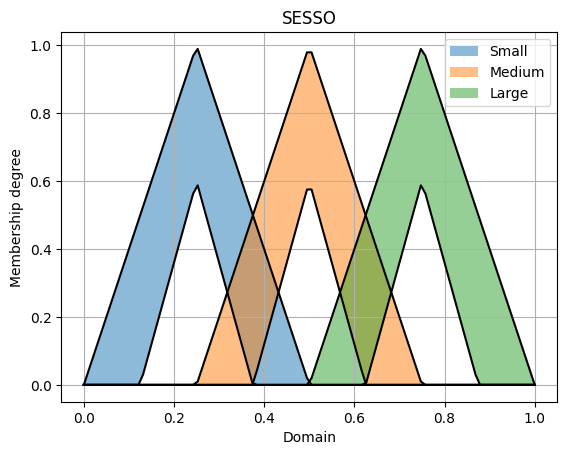

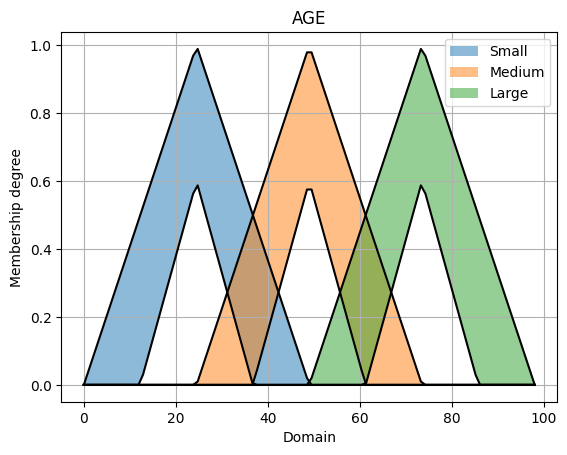

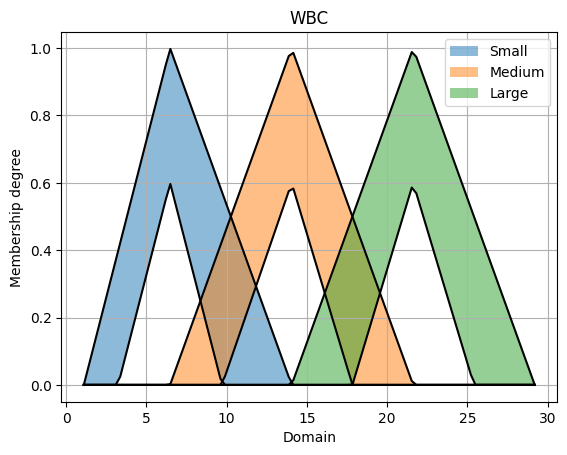

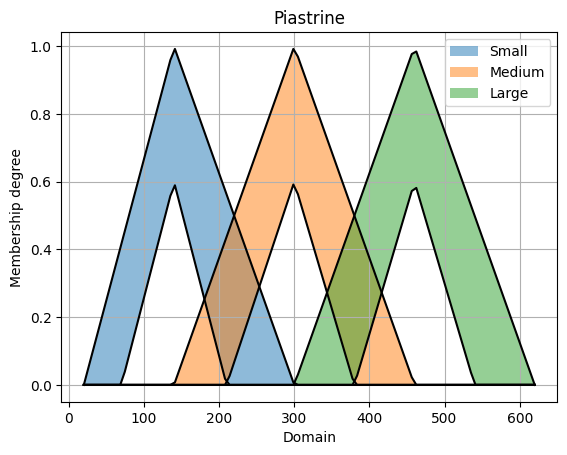

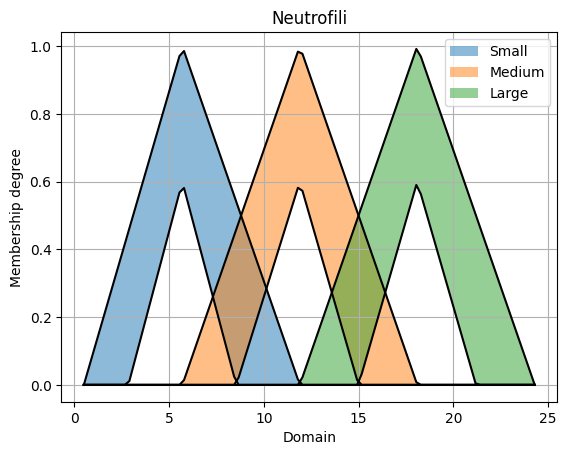

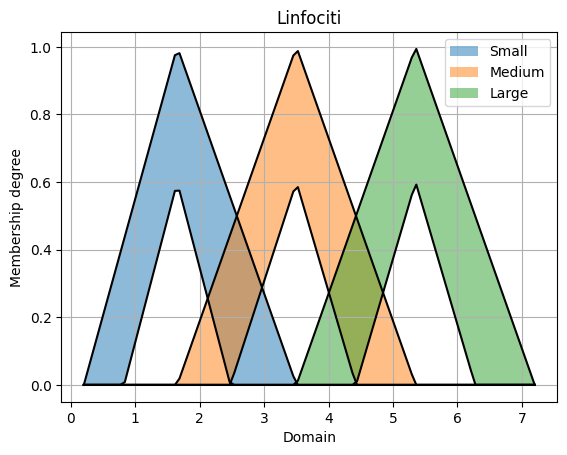

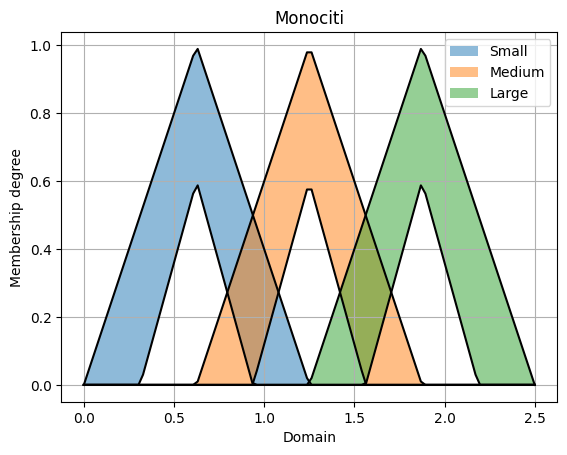

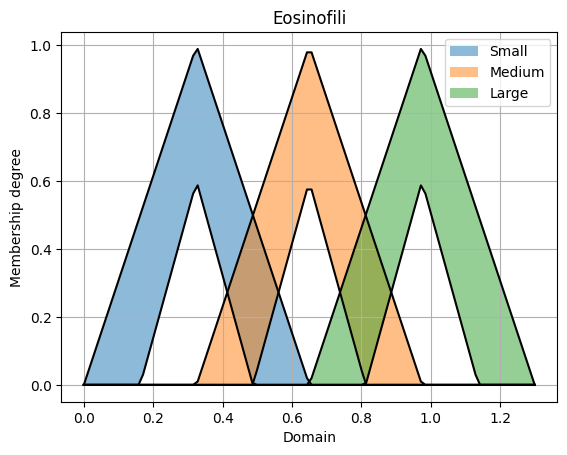

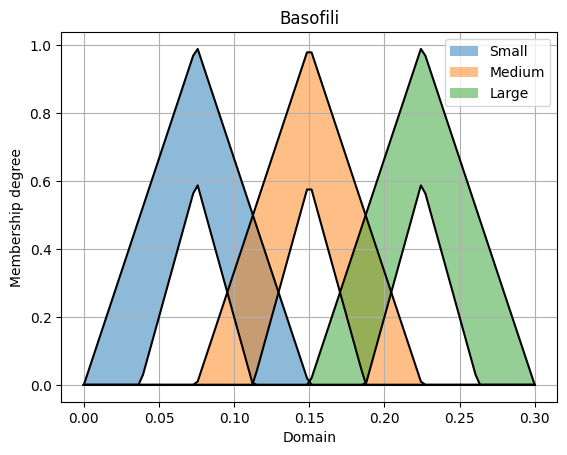

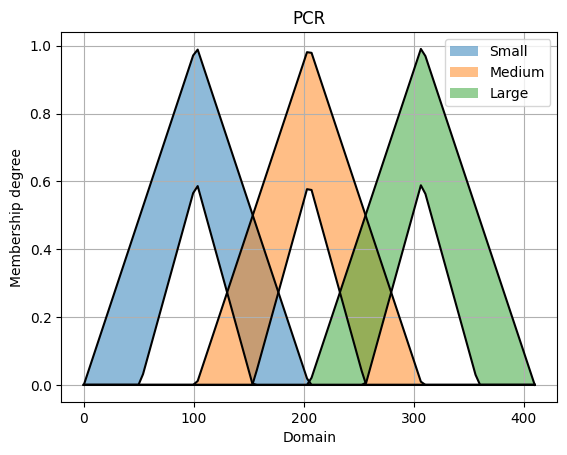

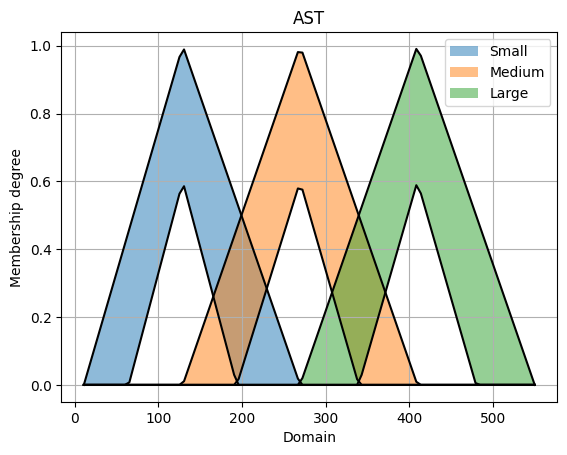

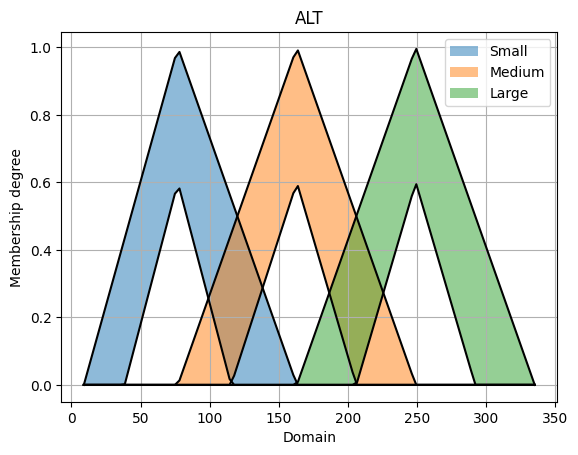

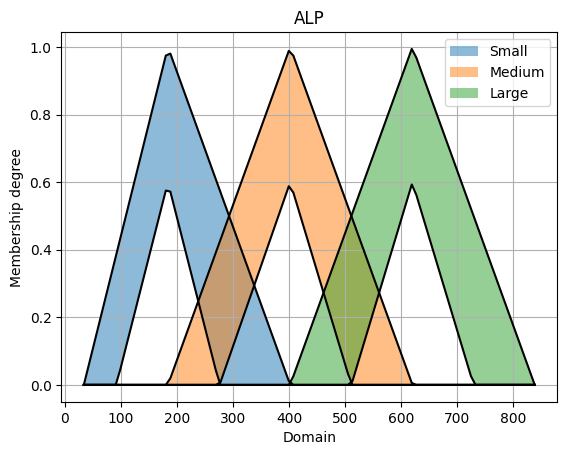

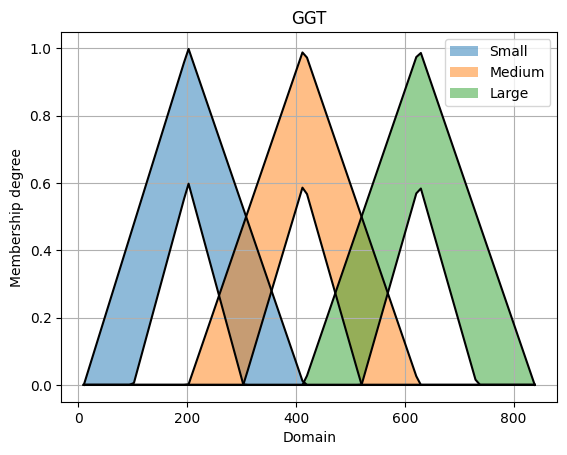

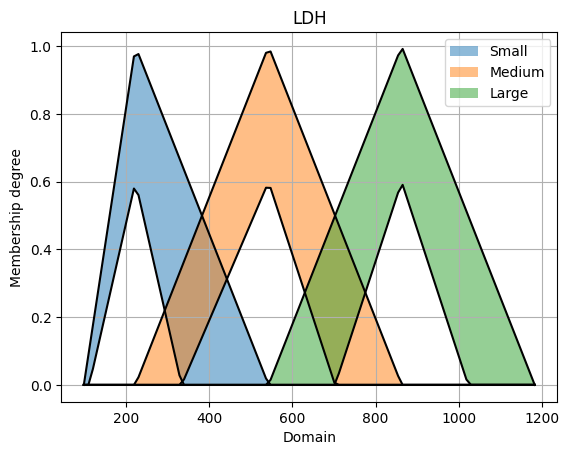

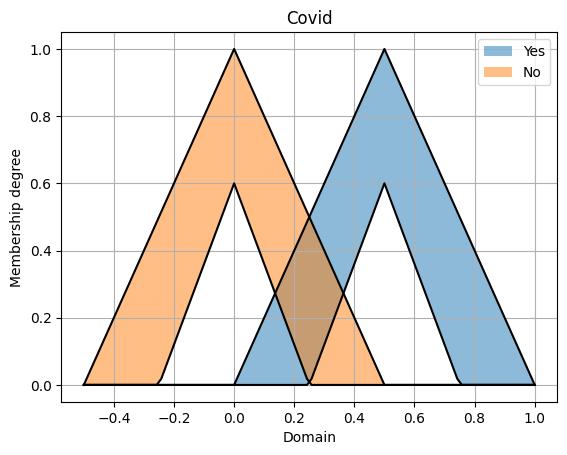

In [29]:
feature_names = ["SESSO", "AGE", "WBC", "Piastrine", "Neutrofili", "Linfociti", "Monociti", "Eosinofili", "Basofili", "PCR", "AST", "ALT", "ALP", "GGT", "LDH"]
all_features = train_dataset[:,0:-1]

all_feature_fuzzy_variables = []

for feature_index in range(15):
    feature_col = all_features[:, feature_index]
    feature_dict = {"name": feature_names[feature_index]}
    feature_min = np.min(feature_col)
    feature_max = np.max(feature_col)
    domain = linspace(feature_min, feature_max, 100)
    # bounds = boundries[feature_index]
    median =  (feature_max - feature_min) / 2
    Small = IT2FS(domain, 
              trapezoid_mf, [feature_min, (median-feature_min)/2,(median-feature_min)/2, median, 1],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [(median-feature_min)/4, (median-feature_min)/2, (median-feature_min)*(3/4), 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
    Medium = IT2FS(domain, 
              trapezoid_mf, [(median-feature_min)/2, median, median, median + (feature_max - median)/2, 1.],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [(median-feature_min)*(3/4), median, median + (feature_max - median)/4, 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
    Large = IT2FS(domain, 
              trapezoid_mf, [median,  median + (feature_max - median)/2,  median + (feature_max - median)/2, feature_max, 1.],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [median + (feature_max - median)/4, median + (feature_max - median)/2, median + ((feature_max - median)*(3/4)), 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
    feature_dict["Small"] = Small
    feature_dict["Medium"] = Medium
    feature_dict["Large"] = Large
    all_feature_fuzzy_variables.append(feature_dict)
# print(all_feature_fuzzy_variables)
    # IT2FS_plot(Small, Medium, Large, legends=["Small", "Medium", "Large"], title=feature_names[feature_index])
import matplotlib.pyplot as plt
for i in range(15):
    # plt.subplot(1, 15, i+1)
    IT2FS_plot(all_feature_fuzzy_variables[i]["Small"], all_feature_fuzzy_variables[i]["Medium"], all_feature_fuzzy_variables[i]["Large"], legends=["Small", "Medium", "Large"], title=feature_names[i], filename=f"type2fuzzyVariables/{feature_names[i]}")

# myIT2FLS = Mamdani(min_t_norm, max_s_norm)

domain = linspace(-0.5, 1, 100)
Yes = IT2FS(domain, 
              trapezoid_mf, [0, 0.5, 0.5, 1, 1.],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [0.25, 0.5, 0.75, 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
No = IT2FS(domain, 
              trapezoid_mf, [-0.5, 0, 0, 0.5, 1.],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [-0.25, 0, 0.25, 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
IT2FS_plot(Yes, No, legends=["Yes", "No"], title="Covid")




In [30]:
import pickle
with open('rules.pkl', 'rb') as f:
    rules = pickle.load(f)

In [31]:
myIT2FLS = IT2FLS()
myIT2FLS.add_input_variable("PCR")
myIT2FLS.add_output_variable("Covid")
# myIT2FLS.add_output_variable("No_Covid")
convert_dict = {"poor": "Small", "average": "Medium", "good": "Large"}

for i in range(len(rules)):
    rule = rules[i]
    # conseq = [("Covid", convert_dict[rule.consequent[0].term.label])]
    # print(conseq)
    if rule.consequent[0].term.parent.label == "no_covid":
        conseq = [("Covid", No)]
    else:
        conseq = [("Covid", Yes)]
    one_rule_antecidents = []
    pcr = rule.antecedent.term1.term1.term1.term1.term1.term2
    
    myIT2FLS.add_rule([(pcr.parent.label, all_feature_fuzzy_variables[9][convert_dict[pcr.label]])], conseq)
    # for i in range(15):
    #     try:
    #         antecedent = rule.term2
    #     except:
    #         antecedent = rule
    #         one_rule_antecidents.append((antecedent.parent.label, all_feature_fuzzy_variables[14-i][convert_dict[antecedent.label]]))
    #         break
    #     one_rule_antecidents.append((antecedent.parent.label, all_feature_fuzzy_variables[14-i][convert_dict[antecedent.label]]))
    #     rule = rule.term1
    # # print(convert_dict[rule.term2.label])

    # myIT2FLS.add_rule(one_rule_antecidents, conseq)
print(len(myIT2FLS.rules))
myIT2FLS.rules

208


[([('PCR',
    Interval type 2 fuzzy set with trapezoid_mf UMF function with [0.1, 102.425, 102.425, 204.95, 1] parameters, and tri_mf LMF function with [51.2125, 102.425, 153.6375, 0.6] parameters.)],
  [('Covid',
    Interval type 2 fuzzy set with trapezoid_mf UMF function with [0, 0.5, 0.5, 1, 1.0] parameters, and tri_mf LMF function with [0.25, 0.5, 0.75, 0.6] parameters.)]),
 ([('PCR',
    Interval type 2 fuzzy set with trapezoid_mf UMF function with [0.1, 102.425, 102.425, 204.95, 1] parameters, and tri_mf LMF function with [51.2125, 102.425, 153.6375, 0.6] parameters.)],
  [('Covid',
    Interval type 2 fuzzy set with trapezoid_mf UMF function with [0, 0.5, 0.5, 1, 1.0] parameters, and tri_mf LMF function with [0.25, 0.5, 0.75, 0.6] parameters.)]),
 ([('PCR',
    Interval type 2 fuzzy set with trapezoid_mf UMF function with [102.425, 204.95, 204.95, 307.475, 1.0] parameters, and tri_mf LMF function with [153.6375, 204.95, 256.2125, 0.6] parameters.)],
  [('Covid',
    Interval t

{'PCR': 125.4}
{'Covid': Interval type 2 fuzzy set with <lambda> UMF function with [] parameters, and <lambda> LMF function with [] parameters.}
{'Covid': (-0.020620820875011457, 0.5206208208750114)}


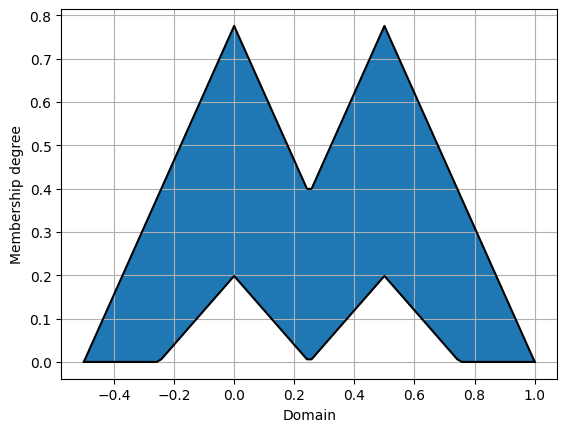

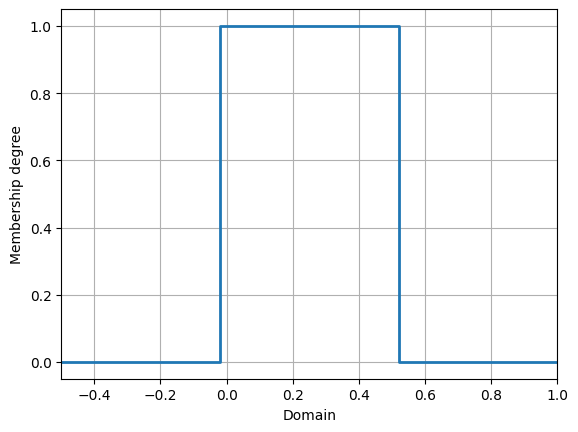

0.24999999999999997
104 104


In [46]:
sample = train_dataset[20,:]
feature_dict = {}
for feature_index in range(9, 10):
    # print(feature_names[feature_index], sample[feature_index])
    feature_dict[feature_names[feature_index]] = sample[feature_index]
domain = linspace(-0.5, 1, 100)
print(feature_dict)
it2out, tr = myIT2FLS.evaluate(feature_dict, product_t_norm, max_s_norm, domain, 
                               method= "Centroid")
print(it2out)
print(tr)
it2out["Covid"].plot()
TR_plot(domain, tr["Covid"])
print(crisp(tr["Covid"]))
true, false = 0, 0
for i in range (train_dataset.shape[0]):
    try:
        sample = train_dataset[i,:]
        feature_dict = {}
        for feature_index in range(9, 14):
            # print(feature_names[feature_index], sample[feature_index])
            feature_dict[feature_names[feature_index]] = sample[feature_index]
        # tipping.compute()
        it2out, tr = myIT2FLS.evaluate(feature_dict, min_t_norm, max_s_norm, domain, 
                               method= "Centroid", algorithm= "EIASC")
        # it2out["Covid"].plot()
        # TR_plot(domain, tr["Covid"])
        # print(crisp(tr["Covid"]))
        value = crisp(tr["Covid"]) * 2
        if value >= 0.5:
            if sample [-1] == 1:
                true += 1
            else: 
                false += 1
            # print(str(sample[-1]) + " : " + "1")
        else:
            if sample [-1] == 0:
                true += 1
            else: 
                false += 1

    except:
        print(i)
        
print(true, false)

In [43]:
true / (true+false)

0.5

In [44]:
# sample = train_dataset[150,:]
# feature_dict = {}
# for feature_index in range(9, 10):
#     # print(feature_names[feature_index], sample[feature_index])
#     feature_dict[feature_names[feature_index]] = sample[feature_index]
# domain = linspace(-0.5, 1, 100)
# print(feature_dict)
# it2out, tr = myIT2FLS.evaluate(feature_dict, product_t_norm, max_s_norm, domain, 
#                                method= "Centroid")
# print(it2out)
# print(tr)
# it2out["Covid"].plot()
# TR_plot(domain, tr["Covid"])
# print(crisp(tr["Covid"]))
true, false = 0, 0
for i in range (test_dataset.shape[0]):
    try:
        sample = test_dataset[i,:]
        feature_dict = {}
        for feature_index in range(9, 14):
            # print(feature_names[feature_index], sample[feature_index])
            feature_dict[feature_names[feature_index]] = sample[feature_index]
        # tipping.compute()
        it2out, tr = myIT2FLS.evaluate(feature_dict, min_t_norm, max_s_norm, domain, 
                               method= "Centroid", algorithm= "EIASC")
        # it2out["Covid"].plot()
        # TR_plot(domain, tr["Covid"])
        # print(crisp(tr["Covid"]))
        value = crisp(tr["Covid"]) * 2
        if value >= 0.5:
            if sample [-1] == 1:
                true += 1
            else: 
                false += 1
            # print(str(sample[-1]) + " : " + "1")
        else:
            if sample [-1] == 0:
                true += 1
            else: 
                false += 1

    except:
        print(i)
        
print(true, false)

37 34


In [40]:
true / (true+false)

0.5211267605633803